In [24]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.impute import IterativeImputer
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
data = pd.read_csv('/content/BO_Training_Dataset.csv')

print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print("Number of categorical featues including Product id and target variable : " , data.select_dtypes(exclude=['int', 'float']).shape[1])
print('Features : ', data.columns.values)

Number of data points :  1048575
Number of features :  23
Number of categorical featues including Product id and target variable :  7
Features :  ['sku' 'national_inv' 'lead_time' 'in_transit_qty' 'forecast_3_month'
 'forecast_6_month' 'forecast_9_month' 'sales_1_month' 'sales_3_month'
 'sales_6_month' 'sales_9_month' 'min_bank' 'potential_issue'
 'pieces_past_due' 'perf_6_month_avg' 'perf_12_month_avg' 'local_bo_qty'
 'deck_risk' 'oe_constraint' 'ppap_risk' 'stop_auto_buy' 'rev_stop'
 'went_on_backorder']


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1048575 non-null  int64  
 1   national_inv       1048575 non-null  int64  
 2   lead_time          984057 non-null   float64
 3   in_transit_qty     1048575 non-null  int64  
 4   forecast_3_month   1048575 non-null  int64  
 5   forecast_6_month   1048575 non-null  int64  
 6   forecast_9_month   1048575 non-null  int64  
 7   sales_1_month      1048575 non-null  int64  
 8   sales_3_month      1048575 non-null  int64  
 9   sales_6_month      1048575 non-null  int64  
 10  sales_9_month      1048575 non-null  int64  
 11  min_bank           1048575 non-null  int64  
 12  potential_issue    1048575 non-null  object 
 13  pieces_past_due    1048575 non-null  int64  
 14  perf_6_month_avg   1048575 non-null  float64
 15  perf_12_month_avg  1048575 non-n

## **imbalanced classes**

In [5]:
data.went_on_backorder.value_counts()

No     1039675
Yes       8900
Name: went_on_backorder, dtype: int64

## **Histogram for all variables**

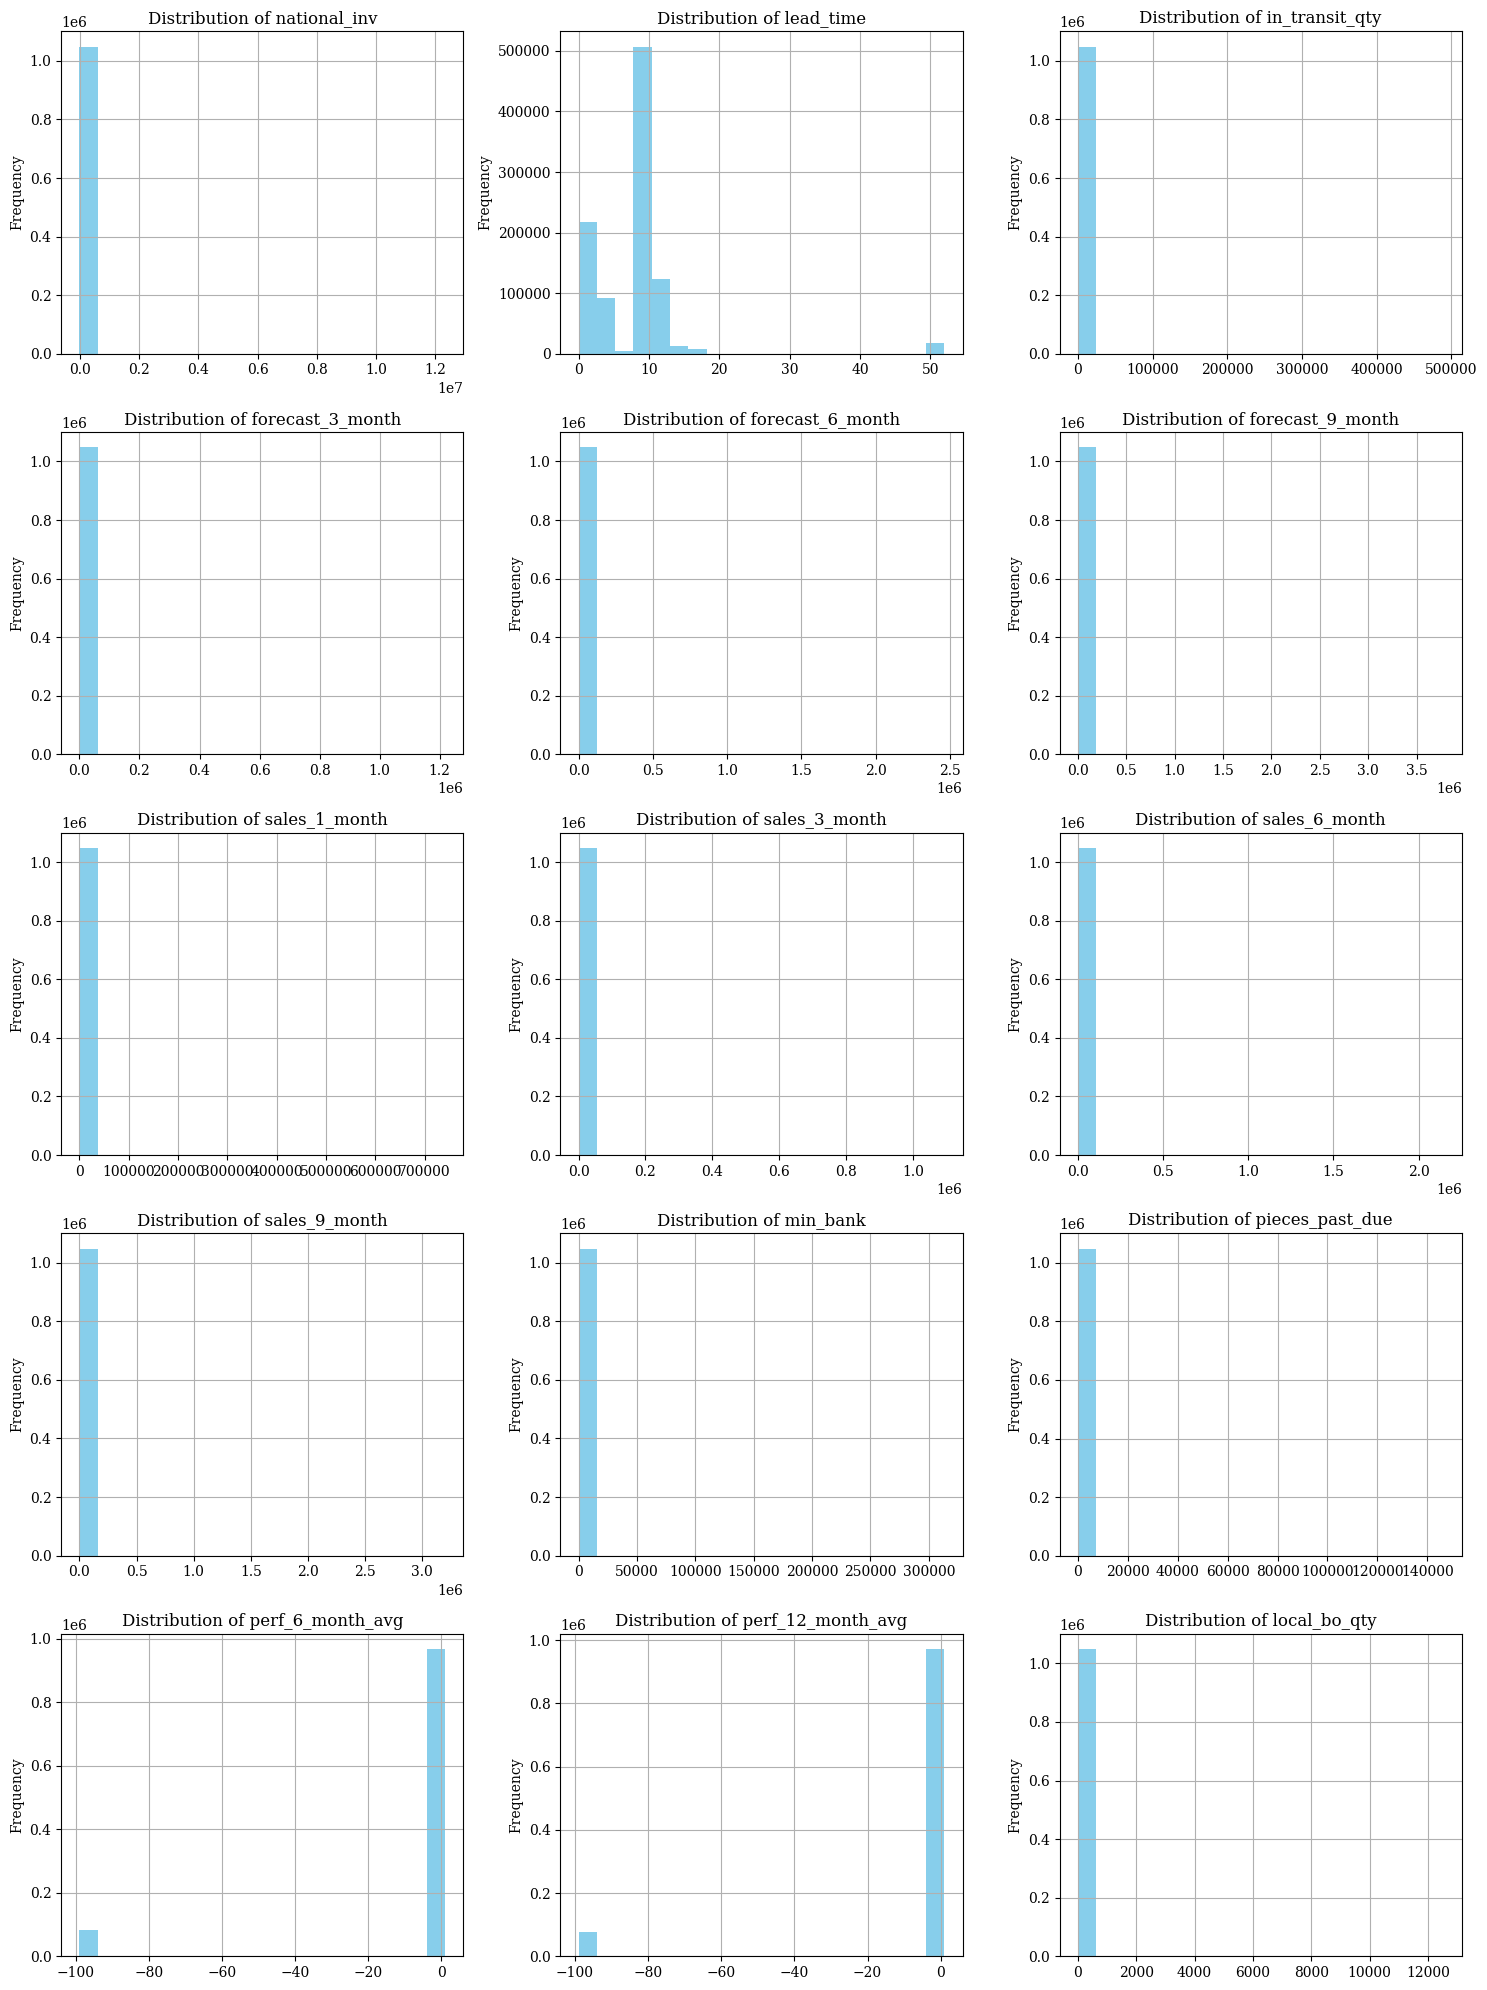

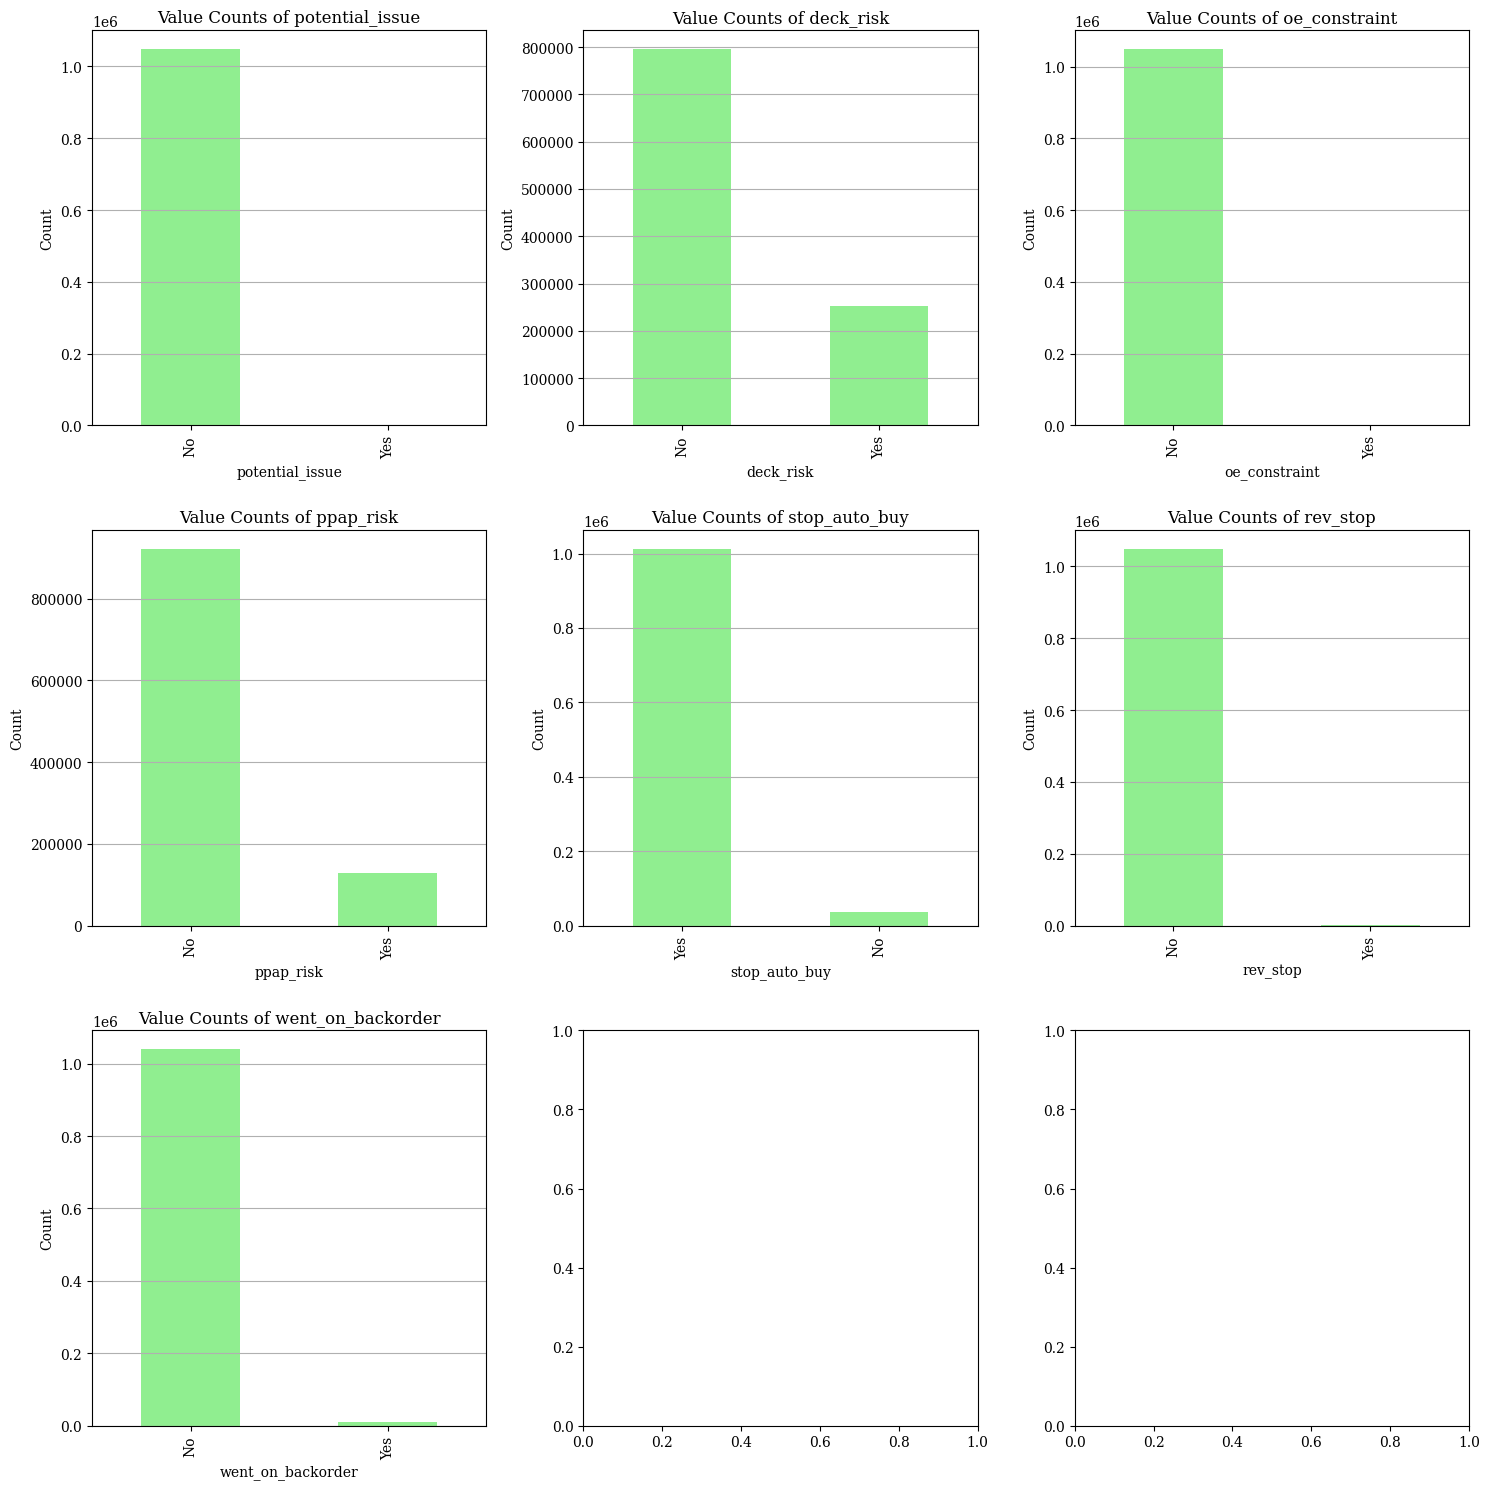

In [6]:
import matplotlib.pyplot as plt

# Histogram for numerical columns
numerical_columns = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
                     'forecast_6_month', 'forecast_9_month', 'sales_1_month',
                     'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
                     'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
                     'local_bo_qty']

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
for i, column in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    axes[row, col].hist(data[column], bins=20, color='skyblue')
    axes[row, col].set_title(f'Distribution of {column}')
    # axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

# Value counts for categorical columns
categorical_columns = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
                       'stop_auto_buy', 'rev_stop', 'went_on_backorder']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, column in enumerate(categorical_columns):
    row = i // 3
    col = i % 3
    data[column].value_counts().plot(kind='bar', ax=axes[row, col], color='lightgreen')
    axes[row, col].set_title(f'Value Counts of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
    axes[row, col].grid(axis='y')

plt.tight_layout()
plt.show()

## **missing data**

In [7]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data.index.name = 'Features'
missing_data

,Total Missing Count,% of Total Observations
Features,,
lead_time,64518,0.061529
sku,0,0.000000
potential_issue,0,0.000000
rev_stop,0,0.000000
stop_auto_buy,0,0.000000
ppap_risk,0,0.000000
oe_constraint,0,0.000000
deck_risk,0,0.000000
local_bo_qty,0,0.000000


## **correlation matrix for categorical variables**

In [8]:
categorical_features = data.select_dtypes(include=[object])

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

correlation_matrix = pd.DataFrame(index=categorical_features.columns, columns=categorical_features.columns)

for col1 in categorical_features.columns:
    for col2 in categorical_features.columns:
        correlation_matrix.loc[col1, col2] = cramers_v(categorical_features[col1], categorical_features[col2])

correlation_matrix

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
potential_issue,0.999255,0.002676,0.016492,0.01089,0.001836,0.0,0.013437
deck_risk,0.002676,0.999997,0.0,0.035223,0.124325,0.009338,0.014449
oe_constraint,0.016492,0.0,0.996855,0.002965,0.001908,0.0,0.0051
ppap_risk,0.01089,0.035223,0.002965,0.999996,0.035236,0.019505,0.010217
stop_auto_buy,0.001836,0.124325,0.001908,0.035236,0.999986,0.050589,0.001844
rev_stop,0.0,0.009338,0.0,0.019505,0.050589,0.998908,0.001374
went_on_backorder,0.013437,0.014449,0.0051,0.010217,0.001844,0.001374,0.999943


## **correlation heatmap categorical variables**

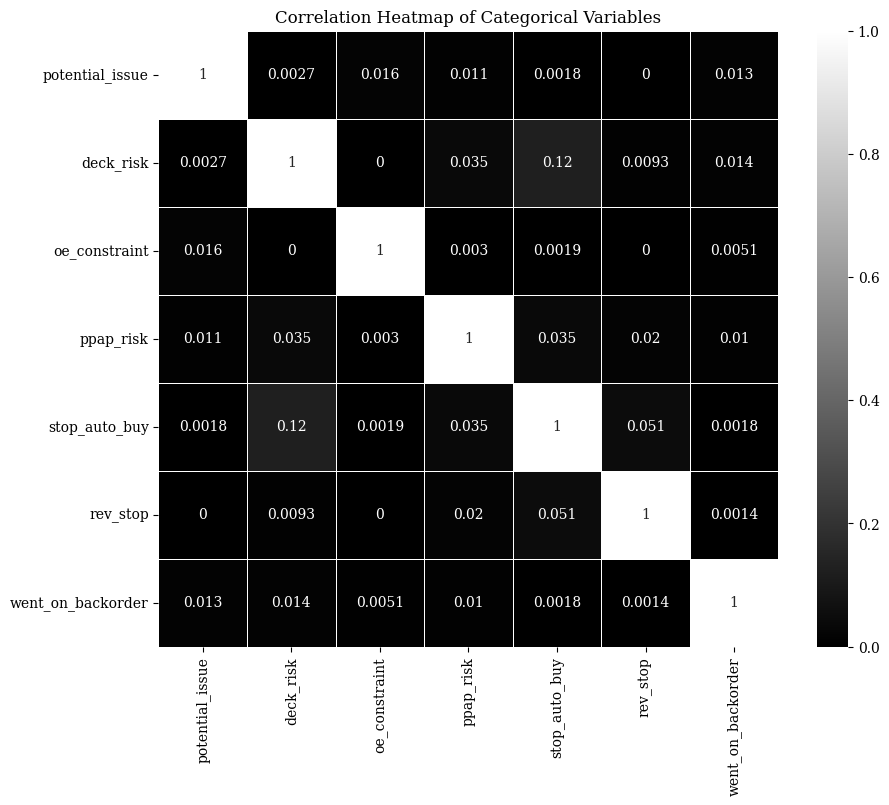

In [9]:
data = np.array([
    [1.0, 0.002676, 0.016492, 0.01089, 0.001836, 0.0, 0.013437],
    [0.002676, 0.999997, 0.0, 0.035223, 0.124325, 0.009338, 0.014449],
    [0.016492, 0.0, 0.996855, 0.002965, 0.001908, 0.0, 0.0051],
    [0.01089, 0.035223, 0.002965, 0.999996, 0.035236, 0.019505, 0.010217],
    [0.001836, 0.124325, 0.001908, 0.035236, 0.999986, 0.050589, 0.001844],
    [0.0, 0.009338, 0.0, 0.019505, 0.050589, 0.998908, 0.001374],
    [0.013437, 0.014449, 0.0051, 0.010217, 0.001844, 0.001374, 0.999943]
])

column_names = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']

df = pd.DataFrame(data, columns=column_names, index=column_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='gray', linewidths=0.5)
plt.title('Correlation Heatmap of Categorical Variables')
plt.show()

## **Chi square**

In [10]:
columns = df.columns.tolist()
chi2_results = pd.DataFrame(index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            observed = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = chi2_contingency(observed)
            chi2_results.at[col1, col2] = chi2

chi2_results

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
potential_issue,NaN,42.0,35.0,42.0,42.0,35.0,42.0
deck_risk,42.0,NaN,35.0,42.0,42.0,35.0,42.0
oe_constraint,35.0,35.0,NaN,35.0,35.0,28.0,35.0
ppap_risk,42.0,42.0,35.0,NaN,42.0,35.0,42.0
stop_auto_buy,42.0,42.0,35.0,42.0,NaN,35.0,42.0
rev_stop,35.0,35.0,28.0,35.0,35.0,NaN,35.0
went_on_backorder,42.0,42.0,35.0,42.0,42.0,35.0,NaN


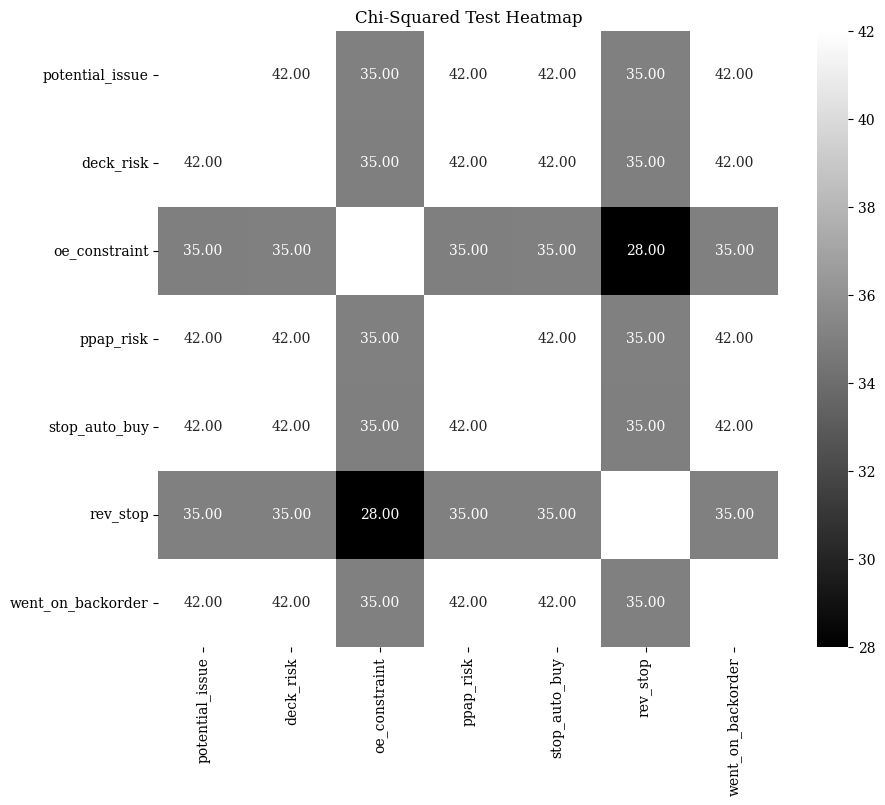

In [11]:
# Convert data to numeric format (float)
chi2_results = chi2_results.apply(pd.to_numeric)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(chi2_results, annot=True, fmt=".2f", cmap="gray")
plt.title("Chi-Squared Test Heatmap")
plt.show()

## **correlations**

<Axes: >

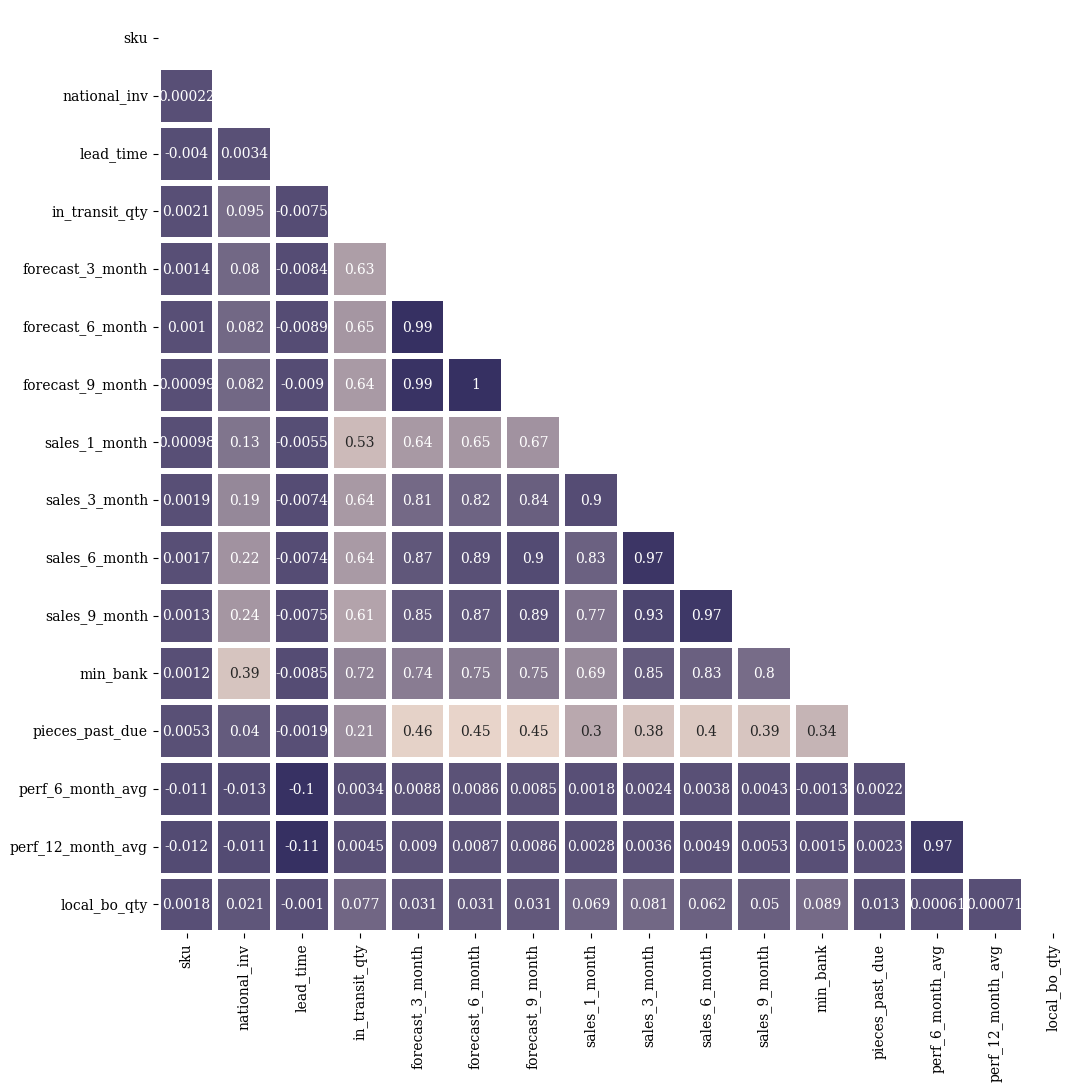

In [20]:
plt.subplots(figsize = (12, 12))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ['#363062',
                                                            '#E9D5CA',
                                                            '#363062',
                                                           ])

mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data.corr(),
            mask = mask,
            cmap = cmap,
            cbar = False,
            square = True,
            annot = True,
            linewidths = 3,
           )

In [21]:
# Drop the columns that are not relevant for the VIF calculation
df = data[['national_inv','lead_time','in_transit_qty','forecast_3_month',
           'forecast_6_month','forecast_9_month',	'sales_1_month',	'sales_3_month',
           'sales_6_month',	'sales_9_month',	'min_bank',	'pieces_past_due',	'perf_6_month_avg',
           'perf_12_month_avg',	'local_bo_qty']]

df.isnull().sum()

national_inv             0
lead_time            64518
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
dtype: int64

## **Multiple imputation**

In [22]:
imputer = IterativeImputer(random_state=0)
imputer.fit(df)
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)
print(df_imputed.isna().sum())

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
dtype: int64


In [23]:
print("checking for infinity")
ds = df_imputed.isin([np.inf, -np.inf]).sum()
print(ds)

checking for infinity
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
dtype: int64


## **variable inflation factor**

In [25]:
# Create a new dataframe to hold the VIF values
vif_df = pd.DataFrame()

# Calculate the VIF scores for all variables
vif_df["feature"] = df_imputed.columns
vif_df["VIF"] = [variance_inflation_factor(df_imputed.values, i) for i in range(df_imputed.shape[1])]

# Identify variables with high VIF scores
high_vif = vif_df[vif_df['VIF'] >= 5]

# Create new DataFrame with variables below the VIF threshold
low_vif = vif_df[vif_df['VIF'] < 5]

# Use the new DataFrame for further analysis
df_low_vif = df_imputed[low_vif['feature']]
df_low_vif

,national_inv,lead_time,in_transit_qty,pieces_past_due,local_bo_qty
0,0.0,14.178930,0.0,0.0,0.0
1,2.0,9.000000,0.0,0.0,0.0
2,2.0,14.178932,0.0,0.0,0.0
3,7.0,8.000000,0.0,0.0,0.0
4,8.0,14.178668,0.0,0.0,0.0
...,...,...,...,...,...
1048570,0.0,2.000000,0.0,0.0,0.0
1048571,359.0,2.000000,176.0,0.0,0.0
1048572,0.0,14.178930,0.0,0.0,0.0
1048573,0.0,2.000000,0.0,0.0,0.0


## **VIF simplified**

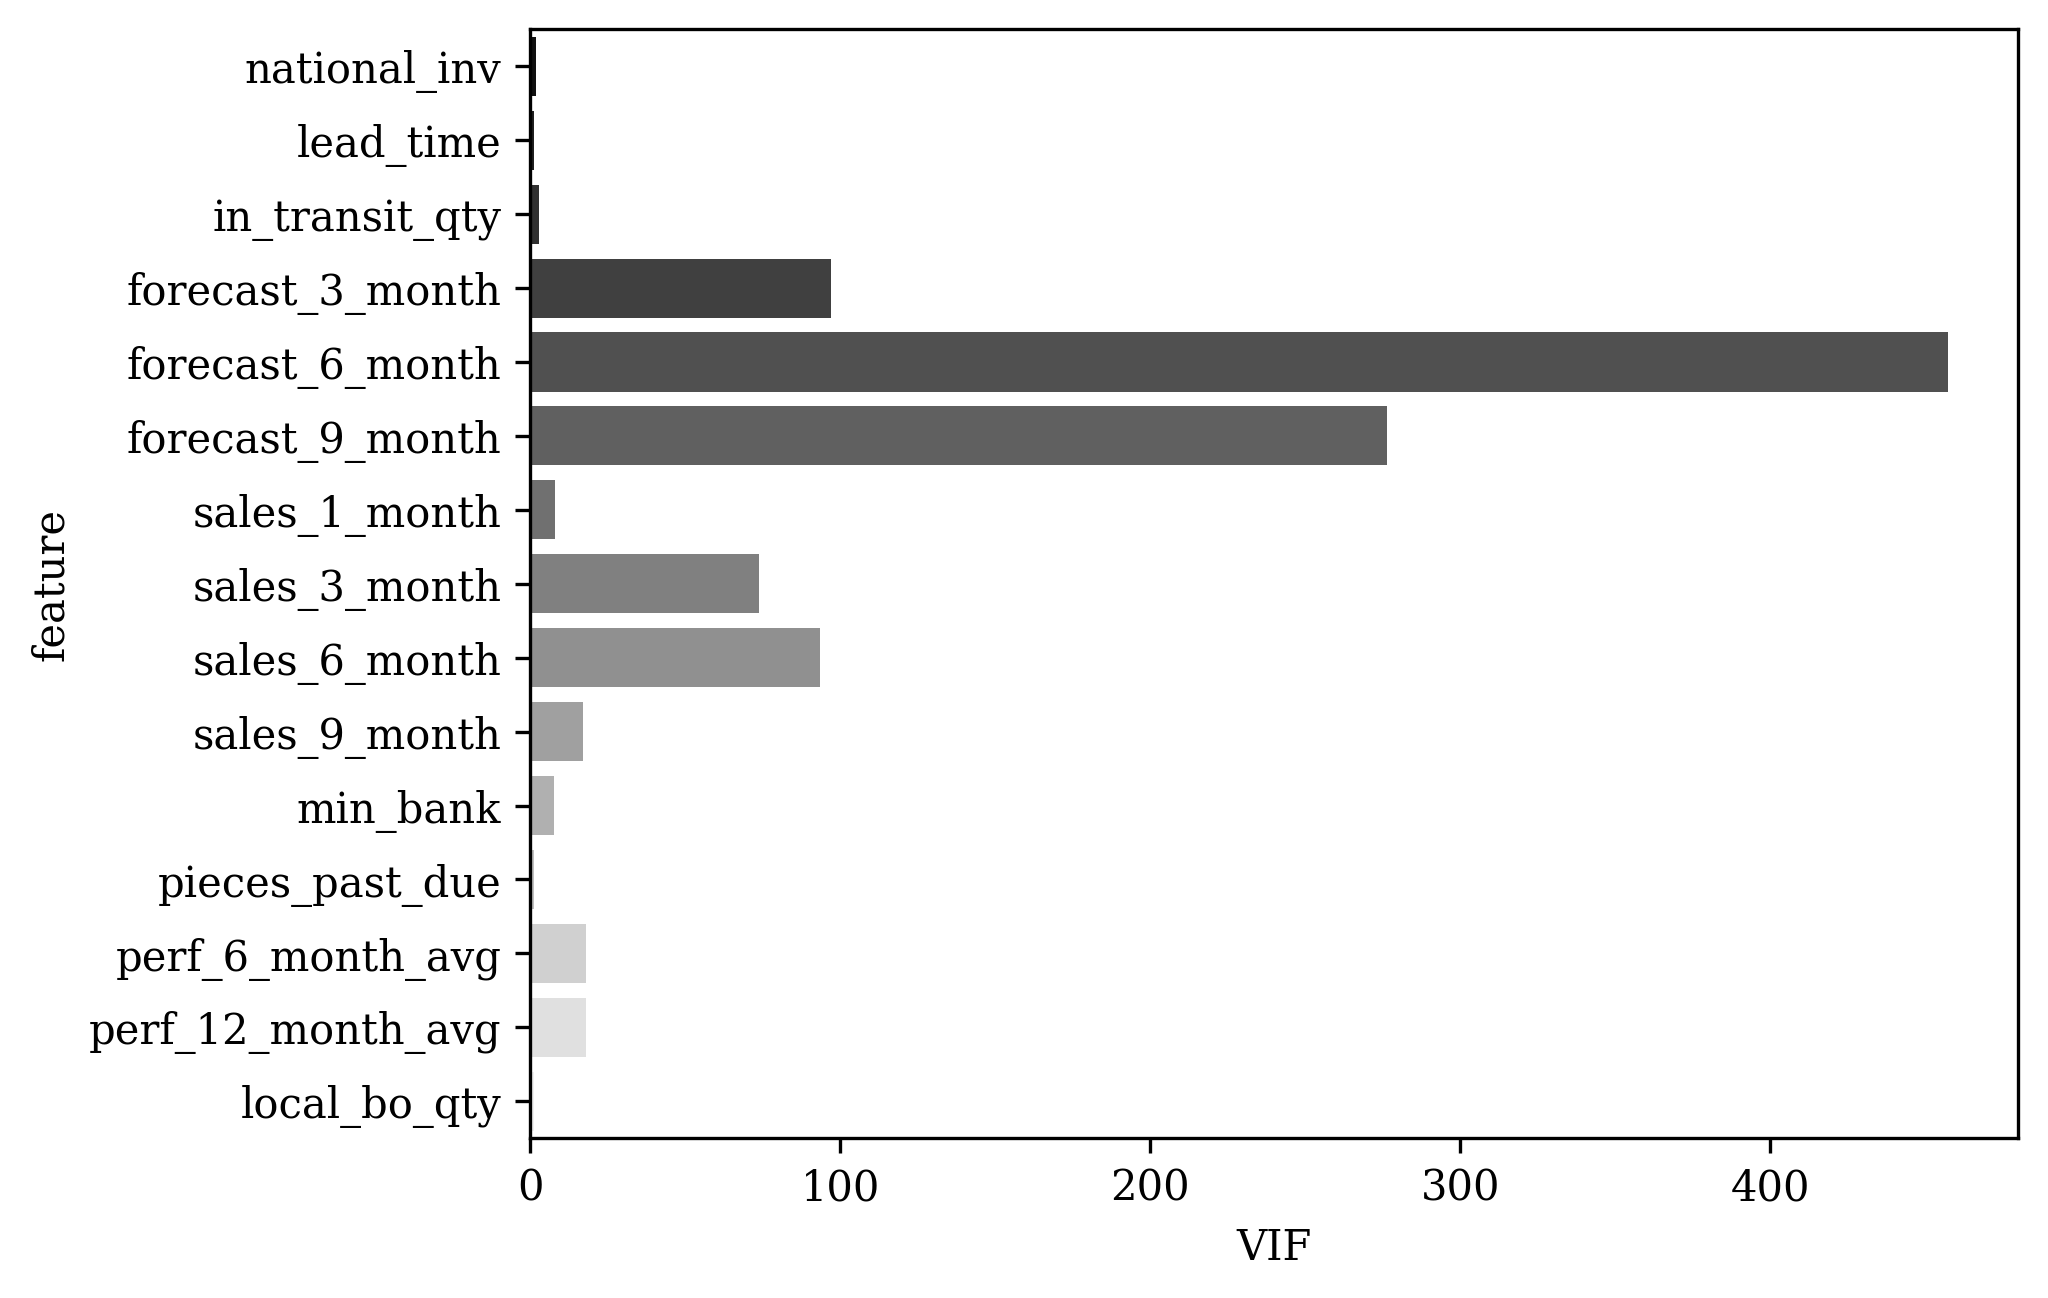

In [26]:
# Calculate the VIF scores for all variables
vif = pd.DataFrame()
vif["feature"] = df_imputed.columns
vif["VIF"] = [variance_inflation_factor(df_imputed.values, i) for i in range(df_imputed.shape[1])]
plt.figure(dpi=300)
sns.barplot(x="VIF", y="feature", data=vif, palette="gray")
plt.show()

In [30]:
# Label encoding categorical variables
cat = data.select_dtypes(include = ['object']).columns
for col in cat:
    data[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    data[col] = data[col].astype(int)

In [31]:
# Replacing -99.0 in performance columns with nan for imputing
data.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)
data.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)

In [32]:
# Define the imputer
imputer = IterativeImputer(random_state=0)
imputer.fit(data)
imputedData = pd.DataFrame(imputer.transform(data), columns=data.columns)
print(imputedData.isna().sum())

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64


In [33]:
# Calculate the VIF scores for all variables
vif = pd.DataFrame()
vif["feature"] = imputedData.iloc[:, :-1].columns
vif["VIF"] = [variance_inflation_factor(imputedData.iloc[:, :-1].values, i) for i in range(imputedData.iloc[:, :-1].shape[1])]
vif

,feature,VIF
0,sku,14.773511
1,national_inv,1.830626
2,lead_time,2.350602
3,in_transit_qty,2.640866
4,forecast_3_month,96.857555
5,forecast_6_month,457.308445
6,forecast_9_month,276.385507
7,sales_1_month,7.988719
8,sales_3_month,73.756321
9,sales_6_month,93.482692


In [27]:
# Change categorical features from string to numerical
cat_cols = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
for col_name in cat_cols:
    data[col_name] = data[col_name].map({'No':0.0, 'Yes':1.0})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1048575 non-null  int64  
 1   national_inv       1048575 non-null  int64  
 2   lead_time          984057 non-null   float64
 3   in_transit_qty     1048575 non-null  int64  
 4   forecast_3_month   1048575 non-null  int64  
 5   forecast_6_month   1048575 non-null  int64  
 6   forecast_9_month   1048575 non-null  int64  
 7   sales_1_month      1048575 non-null  int64  
 8   sales_3_month      1048575 non-null  int64  
 9   sales_6_month      1048575 non-null  int64  
 10  sales_9_month      1048575 non-null  int64  
 11  min_bank           1048575 non-null  int64  
 12  potential_issue    1048575 non-null  float64
 13  pieces_past_due    1048575 non-null  int64  
 14  perf_6_month_avg   1048575 non-null  float64
 15  perf_12_month_avg  1048575 non-n